In [8]:
pip install scikit-learn imbalanced-learn pandas matplotlib plotnine joblib seaborn category-encoders xgboost lightgbm

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
from plotnine import *
import matplotlib.pyplot as plt
import warnings, os, json
from IPython.display import display
from pathlib import Path

In [10]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)
pd.set_option("display.width",None)

In [11]:
# PLOT THEME
theme_set(
        theme_minimal()
          + theme(
            figure_size=(18, 8),
            text=element_text(size=11),
            plot_title=element_text(size=16, fontweight="bold"),
            plot_subtitle=element_text(size=12, fontstyle="italic"),
            axis_title= element_text(size=12),
            axis_text=element_text(size=10),
             legend_text=element_text(size=10),
                     legend_position="bottom",
                     )
            )
    

In [12]:
#Paths
RAW_CSV="311_2023.csv"
OUT_DIR=Path("processed_data")
OUT_DIR.mkdir(parents=True,exist_ok=True)
ARTIFACT_DIR=Path("artifacts")
ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

In [13]:
#DATA LOADING
lights=pd.read_csv(RAW_CSV)
print("Dataset shape:", lights.shape)
      

Dataset shape: (173245, 19)


In [14]:
#General overview of the Data set
display(lights.head())

,service_request_id,requested_datetime,probyear,updated_datetime,closed_date,status_description,status_notes,source,service_name,description,agency_responsible,address,longitude,latitude,zip_code,council_district,ObjectId,x,y
0,SR-MTRO-23-000601,1/3/2023 5:00:00 AM,2023,NaN,NaN,OPEN,NaN,Call Center,NSR Metro Agencies,NaN,NaN,NaN,-85.740657,38.283469,NaN,NaN,1,-9.544606e+06,4.619548e+06
1,SR-MTRO-23-000602,1/3/2023 5:00:00 AM,2023,NaN,NaN,OPEN,NaN,Call Center,NSR Metro Agencies,NaN,NaN,NaN,-85.740657,38.283469,NaN,NaN,2,-9.544606e+06,4.619548e+06
2,SR-EXT-23-000603,1/3/2023 5:00:00 AM,2023,10/3/2024 4:00:00 AM,10/3/2024 4:00:00 AM,CLOSED,NaN,NaN,Exterior,Back door of house was kicked in and has now b...,NaN,1118 GOSS AVE,-85.734237,38.226281,40217.0,15.0,3,-9.543892e+06,4.611441e+06
3,SR-MTRO-23-000604,1/3/2023 5:00:00 AM,2023,NaN,NaN,OPEN,NaN,Call Center,NSR Metro Agencies,NaN,NaN,NaN,-85.740657,38.283469,NaN,NaN,4,-9.544606e+06,4.619548e+06
4,SR-MTRO-23-000605,1/3/2023 5:00:00 AM,2023,NaN,NaN,OPEN,NaN,Call Center,NSR Metro Agencies,NaN,NaN,NaN,-85.740657,38.283469,NaN,NaN,5,-9.544606e+06,4.619548e+06


In [15]:
#Calaculate basic dataset dimensions
n_rows, n_cols= lights.shape
# Displays the data set size and information
print("Dataset Dimensions:")
print(f"-Total observations(rows): {n_rows:,}")
print(f"-Total observations(rows): {n_cols:,}")

Dataset Dimensions:
-Total observations(rows): 173,245
-Total observations(rows): 19


In [16]:
#Classify variables by type
all_cols=lights.columns.tolist()

# Get numeric and categorical variables


In [17]:
#Duplicates
duplicate_count= lights.duplicated().sum()
display(pd.DataFrame({'Duplicate_Rows':[duplicate_count]}))

,Duplicate_Rows
0,0


In [18]:
#Missing value summary
missing_data = lights.isnull().sum()
missing_pct = (missing_data/ len(lights))*100
missing_summary = (pd.DataFrame({
    "Variable": missing_data.index,
    "Missing_count": missing_data.values,
    "Missing_Percentage": missing_pct.values
})
.query("Missing_count > 0") # Change "Missing_Count" to "Missing_count"
.sort_values("Missing_count", ascending=False)
)

print("\nMissing values summary:")
print(f"Total variables with missing values:{len(missing_summary)}")
print(f"Variables with >50% missing: {sum(missing_summary['Missing_Percentage']>50)}")
print(f"Variables with >20% missing: {sum(missing_summary['Missing_Percentage']>20)}")
if len(missing_summary)>0:
    display(missing_summary.head(10).round(2))
   


Missing values summary:
Total variables with missing values:11
Variables with >50% missing: 2
Variables with >20% missing: 9


,Variable,Missing_count,Missing_Percentage
6,status_notes,173245,100.00
10,agency_responsible,151225,87.29
9,description,80436,46.43
4,closed_date,79461,45.87
14,zip_code,70056,40.44
11,address,68943,39.80
15,council_district,67929,39.21
3,updated_datetime,61254,35.36
7,source,55987,32.32
17,x,4,0.00


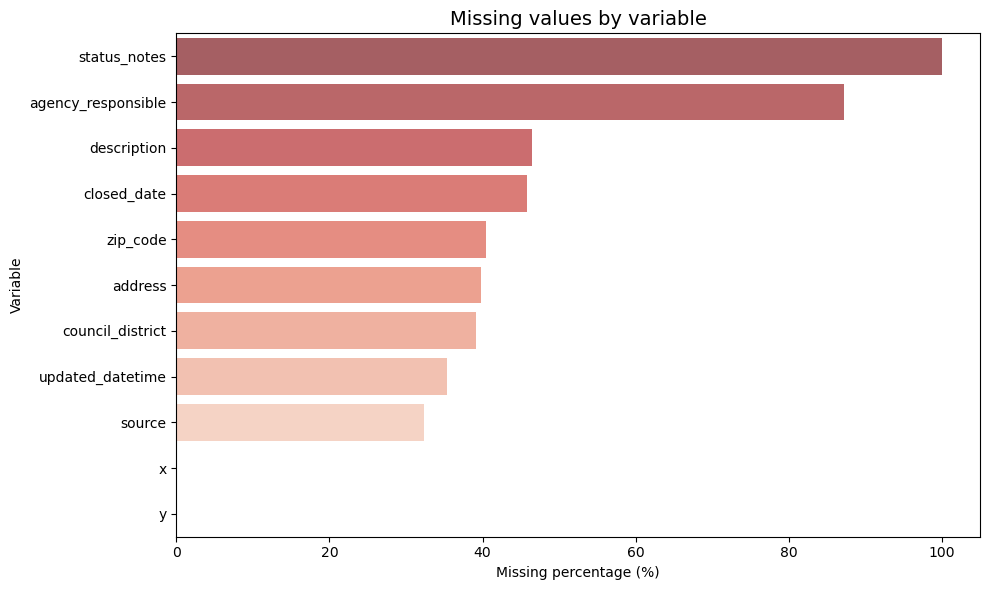

In [19]:
#Horizontal Bar Chart for the Missing value Summary
# Ensure column names match
if len(missing_summary) > 0:
    top_missing = missing_summary.head(15)

    plt.figure(figsize=(10, 6))

    sns.barplot(
        data=top_missing,
        x='Missing_Percentage',
        y='Variable',  # <-- Use the correct column name here
        palette='Reds_r',
        alpha=0.7
    )

    plt.title('Missing values by variable', fontsize=14)
    plt.xlabel('Missing percentage (%)')
    plt.ylabel('Variable')
    plt.tight_layout()
    plt.show()


In [20]:
#Data Cleaning -Dropping Empty Coumns
#Drop empty columns (all NaN values)
lights=lights.dropna(axis=1, how ='all')

#check missing values summary
missing_summary =(
    lights.isnull().mean()
    .reset_index()
    .rename(columns={'index':'variable',0:'Missing_Percentage'})
)

In [21]:
# Drop rows where cleaned district is 0
lights = lights[lights['council_district'] != 0]


In [22]:
lights

,service_request_id,requested_datetime,probyear,updated_datetime,closed_date,status_description,source,service_name,description,agency_responsible,address,longitude,latitude,zip_code,council_district,ObjectId,x,y
0,SR-MTRO-23-000601,1/3/2023 5:00:00 AM,2023,NaN,NaN,OPEN,Call Center,NSR Metro Agencies,NaN,NaN,NaN,-85.740657,38.283469,NaN,NaN,1,-9.544606e+06,4.619548e+06
1,SR-MTRO-23-000602,1/3/2023 5:00:00 AM,2023,NaN,NaN,OPEN,Call Center,NSR Metro Agencies,NaN,NaN,NaN,-85.740657,38.283469,NaN,NaN,2,-9.544606e+06,4.619548e+06
2,SR-EXT-23-000603,1/3/2023 5:00:00 AM,2023,10/3/2024 4:00:00 AM,10/3/2024 4:00:00 AM,CLOSED,NaN,Exterior,Back door of house was kicked in and has now b...,NaN,1118 GOSS AVE,-85.734237,38.226281,40217.0,15.0,3,-9.543892e+06,4.611441e+06
3,SR-MTRO-23-000604,1/3/2023 5:00:00 AM,2023,NaN,NaN,OPEN,Call Center,NSR Metro Agencies,NaN,NaN,NaN,-85.740657,38.283469,NaN,NaN,4,-9.544606e+06,4.619548e+06
4,SR-MTRO-23-000605,1/3/2023 5:00:00 AM,2023,NaN,NaN,OPEN,Call Center,NSR Metro Agencies,NaN,NaN,NaN,-85.740657,38.283469,NaN,NaN,5,-9.544606e+06,4.619548e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173240,SR-HWDS-24-089666,7/28/2023 4:00:00 AM,2023,7/8/2024 4:00:00 AM,7/8/2024 4:00:00 AM,CLOSED,Call Center,High Weeds/Grass,VACANT HOME FRONT AND BACK TALL GRASS ESPECIAL...,NaN,1423 LILLIAN AVE,-85.779931,38.214829,40208.0,6,173241,-9.548978e+06,4.609819e+06
173241,SR-EXT-24-093441,10/26/2023 4:00:00 AM,2023,7/15/2024 4:00:00 AM,7/15/2024 4:00:00 AM,CLOSED,Call Center,Exterior,the citizen reports people living in the garag...,C&R Property Maintenance Enforcement,10808 MARCITIS RD,-85.863212,38.098395,40272.0,25,173242,-9.558249e+06,4.593335e+06
173242,SR-HWDS-24-096460,8/3/2023 4:00:00 AM,2023,7/19/2024 4:00:00 AM,7/19/2024 4:00:00 AM,CLOSED,NaN,High Weeds/Grass,THE CITIZEN REPORTS TALL GRASS AND WEEDS AND T...,NaN,908 BRIDGECREEK RD,-85.493009,38.253396,40245.0,1,173243,-9.517038e+06,4.615284e+06
173243,SR-EXT-24-106985,9/20/2023 4:00:00 AM,2023,8/13/2024 4:00:00 AM,8/13/2024 4:00:00 AM,CLOSED,Call Center,Exterior,Caller reporting someone needs to board up thi...,C&R Property Maintenance Enforcement,631 S 38TH ST,-85.814450,38.253784,40211.0,5,173244,-9.552821e+06,4.615339e+06


In [23]:
lights.shape

(173245, 18)

In [25]:
# Step 1: Convert to string and extract first valid number
lights['council_district_cleaned'] = (
    lights['council_district']
    .astype(str)
    .str.extract(r'(\d+)')[0]  # Extract first numeric group
)

# Step 2: Drop missing or malformed entries
lights = lights.dropna(subset=['council_district_cleaned'])

# Step 3: Convert to integer
lights['council_district_cleaned'] = lights['council_district_cleaned'].astype(int)


In [26]:
# Drop rows where district is 0
lights = lights[lights['council_district_cleaned'] != 0]


In [27]:
district_counts = lights['council_district_cleaned'].value_counts().sort_index()
district_counts

council_district_cleaned
1      5165
2      1953
3      4637
4      7967
5     12087
6      9699
7       773
8     10391
9      5876
10     5445
11      627
12     2343
13     1967
14     2418
15     9809
16      746
17     1087
18     1122
19     1025
20      825
21     7576
22     1226
23     1892
24     2116
25     2971
26     3566
Name: count, dtype: int64

In [28]:
lights.columns

Index(['service_request_id', 'requested_datetime', 'probyear',
       'updated_datetime', 'closed_date', 'status_description', 'source',
       'service_name', 'description', 'agency_responsible', 'address',
       'longitude', 'latitude', 'zip_code', 'council_district', 'ObjectId',
       'x', 'y', 'council_district_cleaned'],
      dtype='object')

In [29]:
lights.shape
lights.head(5)

,service_request_id,requested_datetime,probyear,updated_datetime,closed_date,status_description,source,service_name,description,agency_responsible,address,longitude,latitude,zip_code,council_district,ObjectId,x,y,council_district_cleaned
2,SR-EXT-23-000603,1/3/2023 5:00:00 AM,2023,10/3/2024 4:00:00 AM,10/3/2024 4:00:00 AM,CLOSED,NaN,Exterior,Back door of house was kicked in and has now b...,NaN,1118 GOSS AVE,-85.734237,38.226281,40217.0,15.0,3,-9.543892e+06,4.611441e+06,15
7,SR-MSDS-23-000608,1/3/2023 5:00:00 AM,2023,1/3/2023 5:00:00 AM,NaN,OPEN,Call Center,Solid Waste Missed Services,CALLER REPORTS MISSED RECYCLE THE LAST 3 WEEKS...,NaN,1623 S 28TH ST,-85.801174,38.229072,40211.0,1.0,8,-9.551343e+06,4.611837e+06,1
24,SR-PRKG-23-000625,1/3/2023 5:00:00 AM,2023,1/3/2023 5:00:00 AM,NaN,OPEN,Call Center,Parking Concern,Caller reports a Blue Chevy Cavalier with yell...,LMPD,813 S 39TH ST,-85.816246,38.247422,40211.0,5.0,25,-9.553021e+06,4.614437e+06,5
29,SR-WDEL-23-000630,1/3/2023 5:00:00 AM,2023,1/3/2023 5:00:00 AM,1/3/2023 5:00:00 AM,CLOSED,Call Center,Solid Waste Container Request,CALLER REPORTS THAT THE GARBAGE CART LID IS MI...,NaN,4151 GARLAND AVE,-85.821748,38.247182,40211.0,5.0,30,-9.553633e+06,4.614403e+06,5
30,SR-WDEL-23-000631,1/3/2023 5:00:00 AM,2023,3/13/2023 4:00:00 AM,3/13/2023 4:00:00 AM,CLOSED,NaN,Solid Waste Container Request,No issue,NaN,3823 MANNER DALE DR,-85.632075,38.209070,40220.0,10.0,31,-9.532519e+06,4.609003e+06,10


In [30]:
# Step 1: Replace original column with cleaned version
lights['council_district'] = lights['council_district_cleaned']

# Step 2: Drop the temporary cleaned column
lights = lights.drop(columns=['council_district_cleaned'])


In [31]:
lights.shape

(105309, 18)

In [32]:
lights.head(5)

,service_request_id,requested_datetime,probyear,updated_datetime,closed_date,status_description,source,service_name,description,agency_responsible,address,longitude,latitude,zip_code,council_district,ObjectId,x,y
2,SR-EXT-23-000603,1/3/2023 5:00:00 AM,2023,10/3/2024 4:00:00 AM,10/3/2024 4:00:00 AM,CLOSED,NaN,Exterior,Back door of house was kicked in and has now b...,NaN,1118 GOSS AVE,-85.734237,38.226281,40217.0,15,3,-9.543892e+06,4.611441e+06
7,SR-MSDS-23-000608,1/3/2023 5:00:00 AM,2023,1/3/2023 5:00:00 AM,NaN,OPEN,Call Center,Solid Waste Missed Services,CALLER REPORTS MISSED RECYCLE THE LAST 3 WEEKS...,NaN,1623 S 28TH ST,-85.801174,38.229072,40211.0,1,8,-9.551343e+06,4.611837e+06
24,SR-PRKG-23-000625,1/3/2023 5:00:00 AM,2023,1/3/2023 5:00:00 AM,NaN,OPEN,Call Center,Parking Concern,Caller reports a Blue Chevy Cavalier with yell...,LMPD,813 S 39TH ST,-85.816246,38.247422,40211.0,5,25,-9.553021e+06,4.614437e+06
29,SR-WDEL-23-000630,1/3/2023 5:00:00 AM,2023,1/3/2023 5:00:00 AM,1/3/2023 5:00:00 AM,CLOSED,Call Center,Solid Waste Container Request,CALLER REPORTS THAT THE GARBAGE CART LID IS MI...,NaN,4151 GARLAND AVE,-85.821748,38.247182,40211.0,5,30,-9.553633e+06,4.614403e+06
30,SR-WDEL-23-000631,1/3/2023 5:00:00 AM,2023,3/13/2023 4:00:00 AM,3/13/2023 4:00:00 AM,CLOSED,NaN,Solid Waste Container Request,No issue,NaN,3823 MANNER DALE DR,-85.632075,38.209070,40220.0,10,31,-9.532519e+06,4.609003e+06


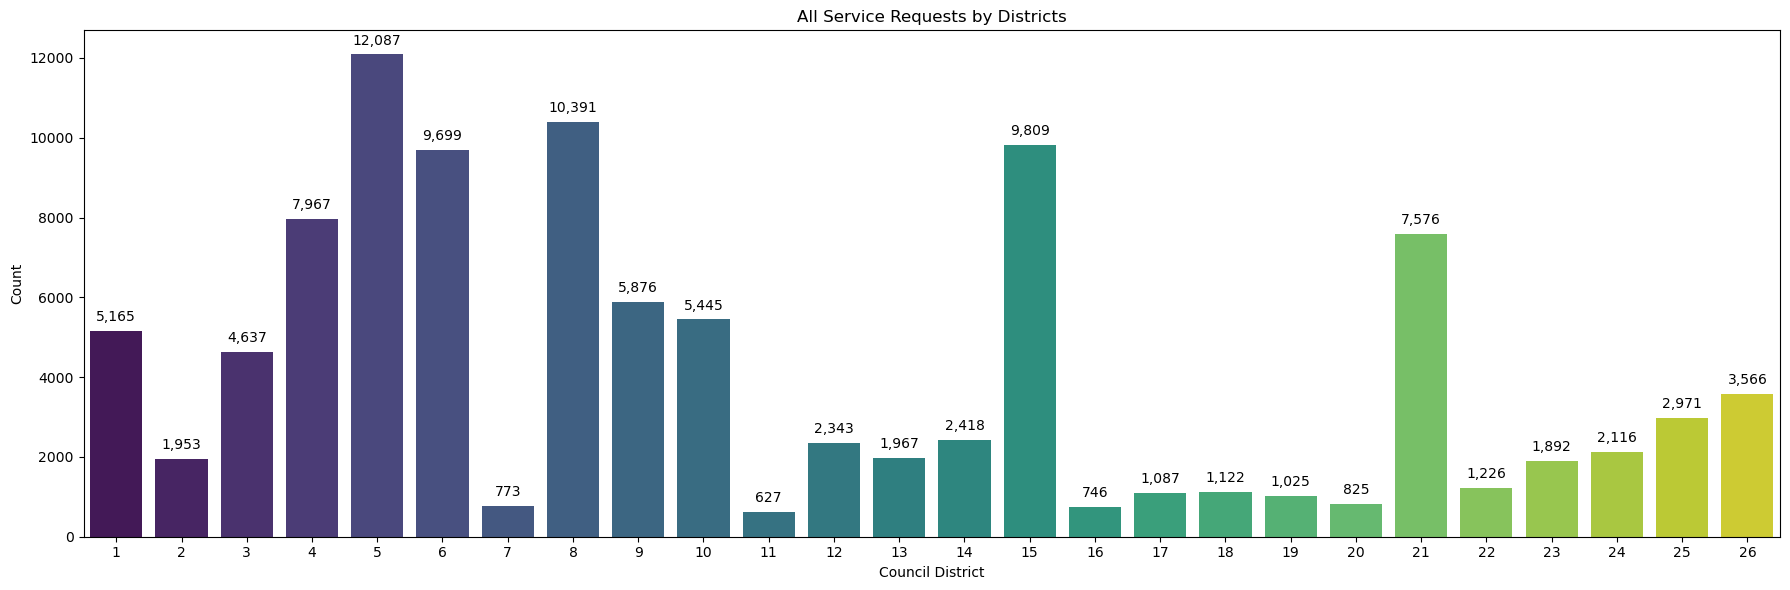

In [33]:

if "council_district" in lights.columns:
    # Get top 26 districts by count
    district_counts = lights["council_district"].value_counts().head(26)

    # Create the plot
    plt.figure(figsize=(18,6))
    ax = sns.barplot(x=district_counts.index, y=district_counts.values, palette="viridis")
    plt.title("All Service Requests by Districts")
    plt.xlabel("Council District")
    plt.ylabel("Count")

    # Annotate each bar using the actual bar height
    for bar in ax.patches:
        height = bar.get_height()
        ax.annotate(f'{int(height):,}',  # format with commas
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords='offset points',
                    ha='center',
                    va='bottom',
                    fontsize=10,
                    color='black')

    plt.tight_layout()
    plt.show()


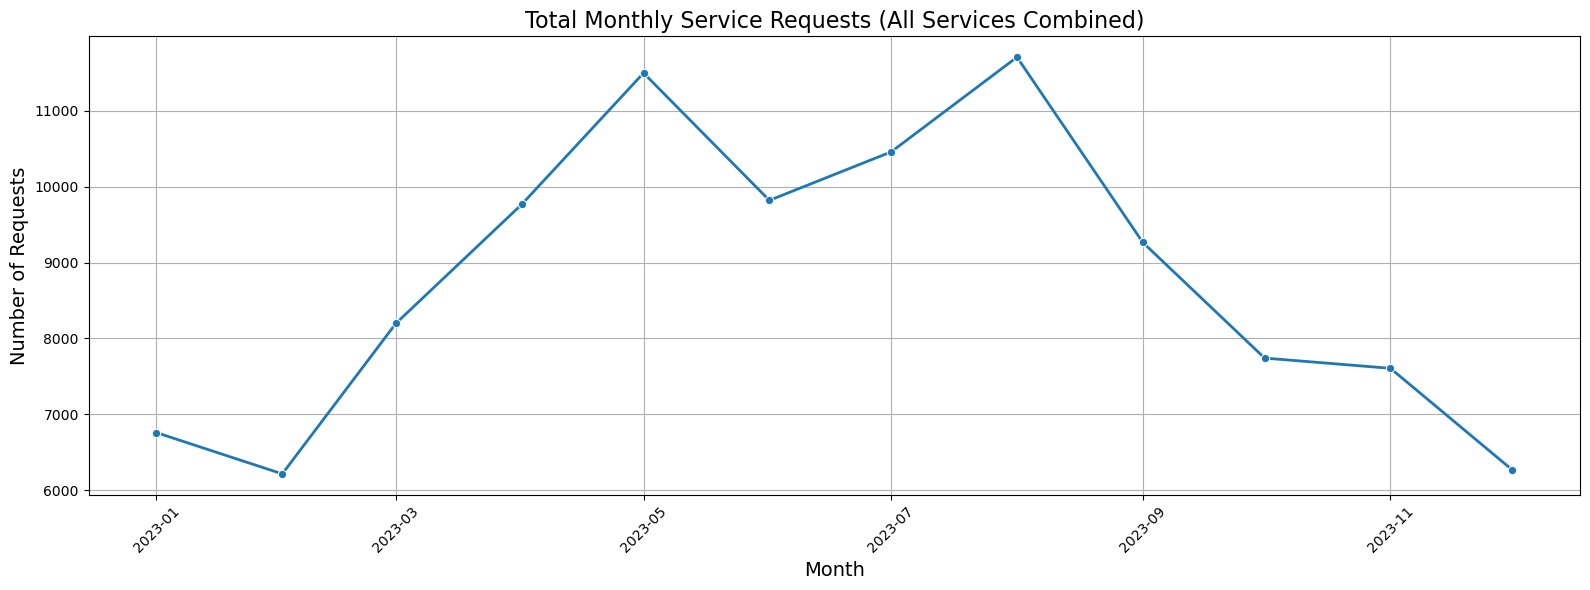

In [35]:

# Step 1: Convert requested_datetime to datetime format
lights['requested_datetime'] = pd.to_datetime(lights['requested_datetime'])

# Step 2: Extract month
lights['month'] = lights['requested_datetime'].dt.to_period('M').dt.to_timestamp()

# Step 3: Group by month and count all requests
monthly_total_requests = (
    lights.groupby('month')
    .size()
    .reset_index(name='count')
)

# Step 4: Plot line graph
plt.figure(figsize=(16, 6))
sns.lineplot(data=monthly_total_requests, x='month', y='count', marker='o', linewidth=2)

# Step 5: Customize chart
plt.title("Total Monthly Service Requests (All Services Combined)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel("Number of Requests", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


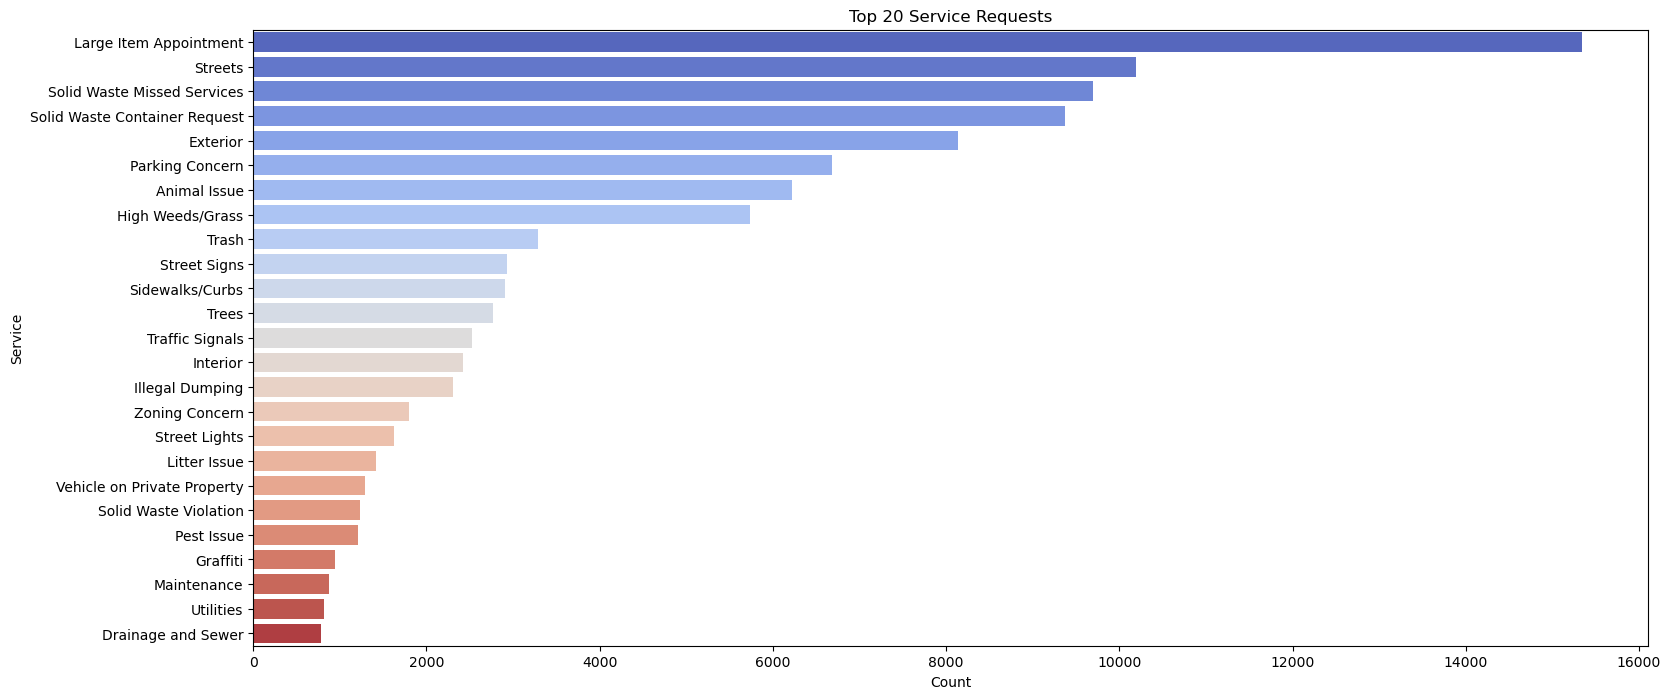

In [36]:
#Group by service type
if "service_name" in lights.columns:
    service_counts = lights["service_name"].value_counts().head(25)
    plt.figure(figsize=(18,8))
    sns.barplot(y=service_counts.index, x=service_counts.values, palette="coolwarm")
    plt.title("Top 20 Service Requests")
    plt.xlabel("Count")
    plt.ylabel("Service")
    plt.show()

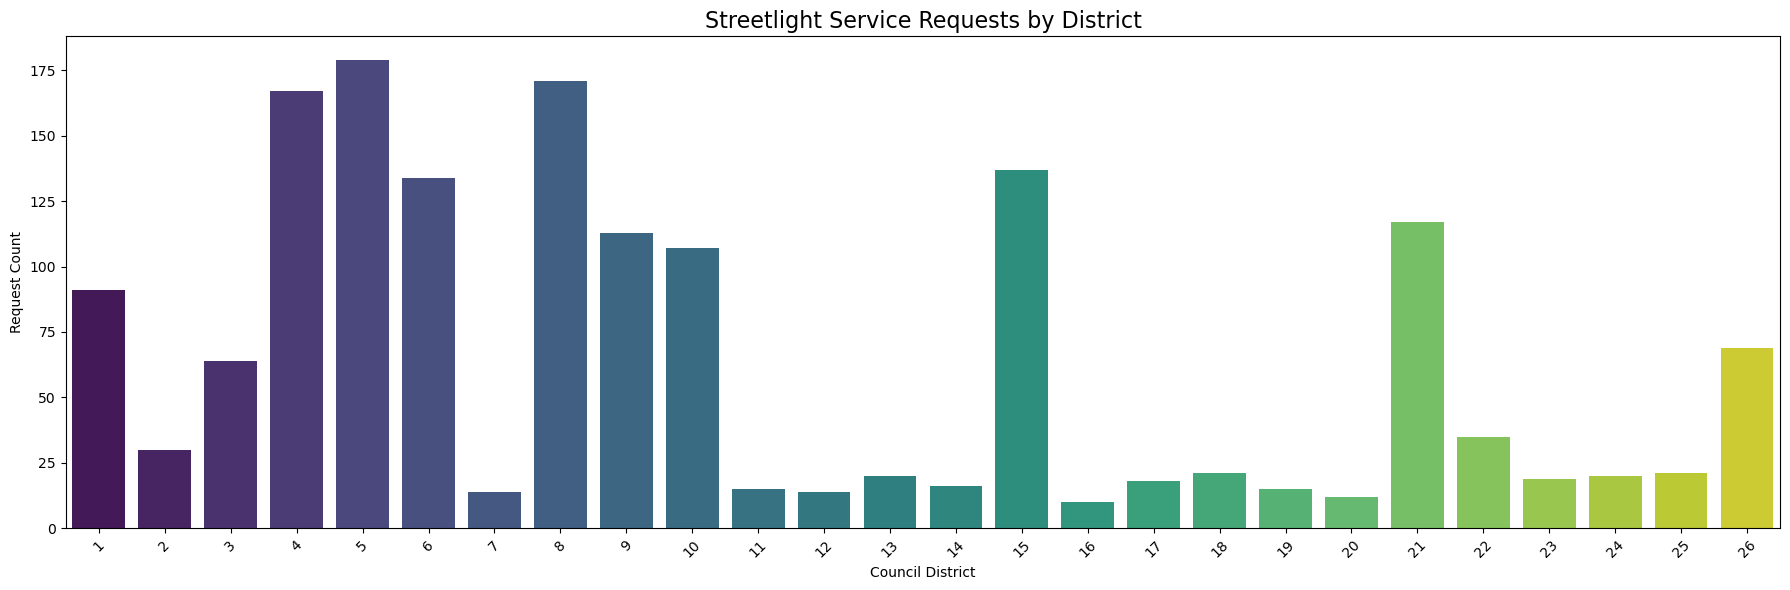

In [37]:


# Filter for streetlight-related requests
streetlight_df = lights[lights['service_name'].str.contains('Street LightS', case=False, na=False)]

# Group by council district
if "council_district" in streetlight_df.columns:
    district_counts = streetlight_df["council_district"].value_counts().head(27)

    plt.figure(figsize=(18, 6))
    sns.barplot(
        x=district_counts.index,
        y=district_counts.values,
        palette="viridis"
    )

    plt.title("Streetlight Service Requests by District", fontsize=16)
    plt.xlabel("Council District")
    plt.ylabel("Request Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [38]:
# Filter for streetlight-related requests
streetlight_df = lights[lights['service_name'].str.contains('Street LightS', case=False, na=False)]

# Convert council_district to string before counting
streetlight_df['council_district'] = streetlight_df['council_district'].astype(str)

# Count requests by council district and sort
district_counts = streetlight_df['council_district'].value_counts().sort_index()

# Display the counts
print(district_counts)


council_district
1      91
10    107
11     15
12     14
13     20
14     16
15    137
16     10
17     18
18     21
19     15
2      30
20     12
21    117
22     35
23     19
24     20
25     21
26     69
3      64
4     167
5     179
6     134
7      14
8     171
9     113
Name: count, dtype: int64


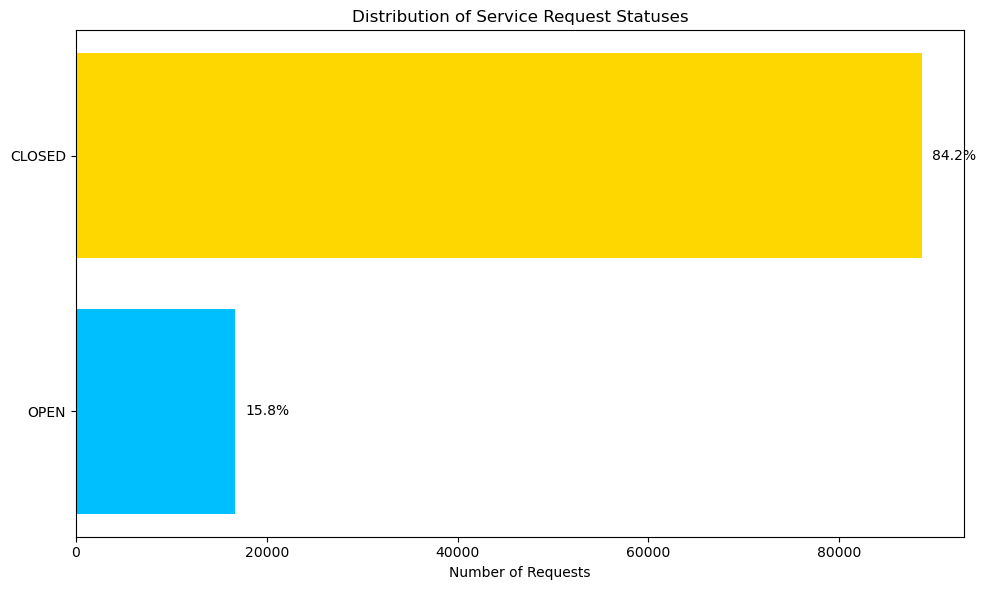

In [39]:
import matplotlib.pyplot as plt

# Step 1: Count occurrences of each status
status_counts = lights['status_description'].value_counts()
total_requests = status_counts.sum()

# Step 2: Define bright custom colors
bright_colors = ['gold', 'deepskyblue', 'limegreen', 'hotpink', 'orange', 'mediumvioletred', 'turquoise', 'coral']

# Step 3: Plot horizontal bar chart
plt.figure(figsize=(10, 6))
bars = plt.barh(
    status_counts.index,
    status_counts.values,
    color=bright_colors[:len(status_counts)]
)

# Step 4: Annotate each bar with percentage
for bar, count in zip(bars, status_counts.values):
    percent = (count / total_requests) * 100
    plt.text(
        count + total_requests * 0.01,  # Slightly offset to the right
        bar.get_y() + bar.get_height() / 2,
        f"{percent:.1f}%",
        va='center', ha='left', fontsize=10, color='black'
    )

# Step 5: Customize chart
plt.xlabel('Number of Requests')
plt.title('Distribution of Service Request Statuses')
plt.gca().invert_yaxis()  # Highest count at the top
plt.tight_layout()
plt.show()


In [40]:

# Step 1: Parse datetime column
lights['requested_datetime'] = pd.to_datetime(lights['requested_datetime'], errors='coerce')

# Step 2: Filter for street light requests
street_light_df = lights[lights['service_name'].str.contains('street light', case=False, na=False)]

# Step 3: Extract month and simplify status
street_light_df['month'] = street_light_df['requested_datetime'].dt.to_period('M')
street_light_df['status_group'] = street_light_df['status_description'].str.contains('closed', case=False, na=False)
street_light_df['status_group'] = street_light_df['status_group'].map({True: 'Closed', False: 'Open'})

# Step 4: Group by month and status
monthly_status_counts = (
    street_light_df
    .groupby(['month', 'status_group'])
    .size()
    .unstack(fill_value=0)
)

# Step 5: Add total column
monthly_status_counts['Total'] = monthly_status_counts.sum(axis=1)

# Step 6: Display the table
print(monthly_status_counts)


status_group  Closed  Open  Total
month                            
2023-01           44   107    151
2023-02           17   122    139
2023-03           16   154    170
2023-04           13   156    169
2023-05           19   102    121
2023-06           17    99    116
2023-07           24    79    103
2023-08           11   146    157
2023-09           20   115    135
2023-10           20    99    119
2023-11           20   134    154
2023-12           17    78     95


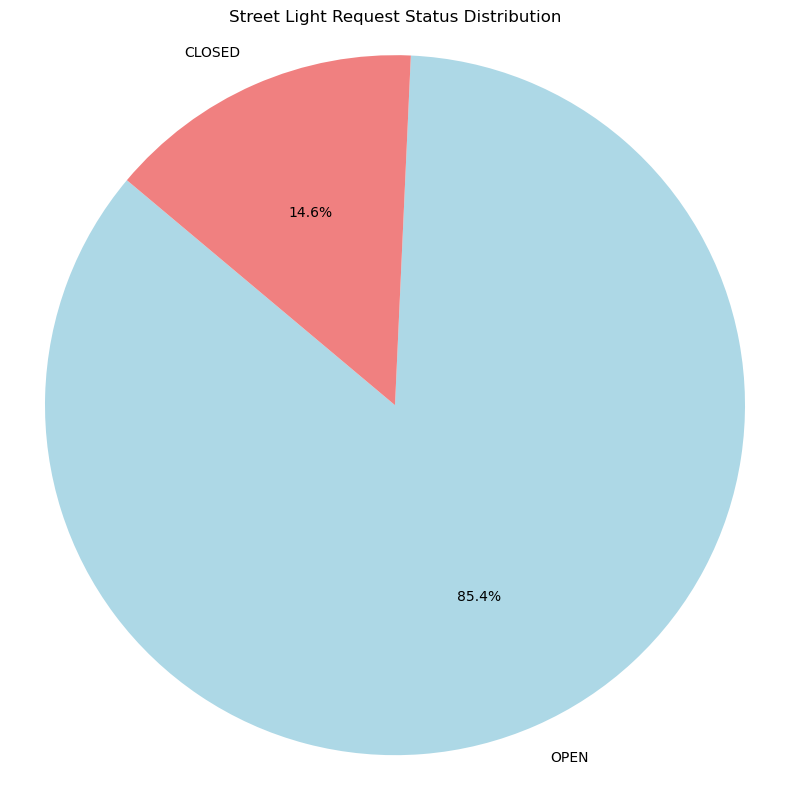

In [41]:
import matplotlib.pyplot as plt

# Step 1: Filter for street light requests
street_light_df = lights[lights['service_name'].str.contains('street light', case=False, na=False)]

# Step 2: Count status descriptions
status_counts = street_light_df['status_description'].value_counts()

# Step 3: Define light pastel colors
light_colors = ['lightblue', 'lightcoral', 'lightgreen', 'plum', 'khaki', 'lavender', 'peachpuff', 'powderblue']

# Step 4: Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    status_counts.values,
    labels=status_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=light_colors[:len(status_counts)]  # Match number of slices
)

# Step 5: Customize chart
plt.title('Street Light Request Status Distribution')
plt.axis('equal')  # Ensures pie is a circle
plt.tight_layout()
plt.show()


In [42]:
# Step 1: Filter for streetlight-related requests
streetlight_df = lights[lights['service_name'].str.contains('Street LightS', case=False, na=False)]

# Step 2: Convert council_district to string
streetlight_df['council_district'] = streetlight_df['council_district'].astype(str)

# Step 3: Count requests by council district and sort
district_counts = streetlight_df['council_district'].value_counts().sort_index()

# Step 4: Convert to DataFrame and add percentage column
district_df = district_counts.reset_index()
district_df.columns = ['council_district', 'request_count']
district_df['percentage'] = (district_df['request_count'] / district_df['request_count'].sum()) * 100

# Step 5: Display the result
print(district_df)


   council_district  request_count  percentage
0                 1             91    5.586249
1                10            107    6.568447
2                11             15    0.920810
3                12             14    0.859423
4                13             20    1.227747
5                14             16    0.982198
6                15            137    8.410068
7                16             10    0.613874
8                17             18    1.104972
9                18             21    1.289134
10               19             15    0.920810
11                2             30    1.841621
12               20             12    0.736648
13               21            117    7.182320
14               22             35    2.148557
15               23             19    1.166360
16               24             20    1.227747
17               25             21    1.289134
18               26             69    4.235727
19                3             64    3.928791
20           

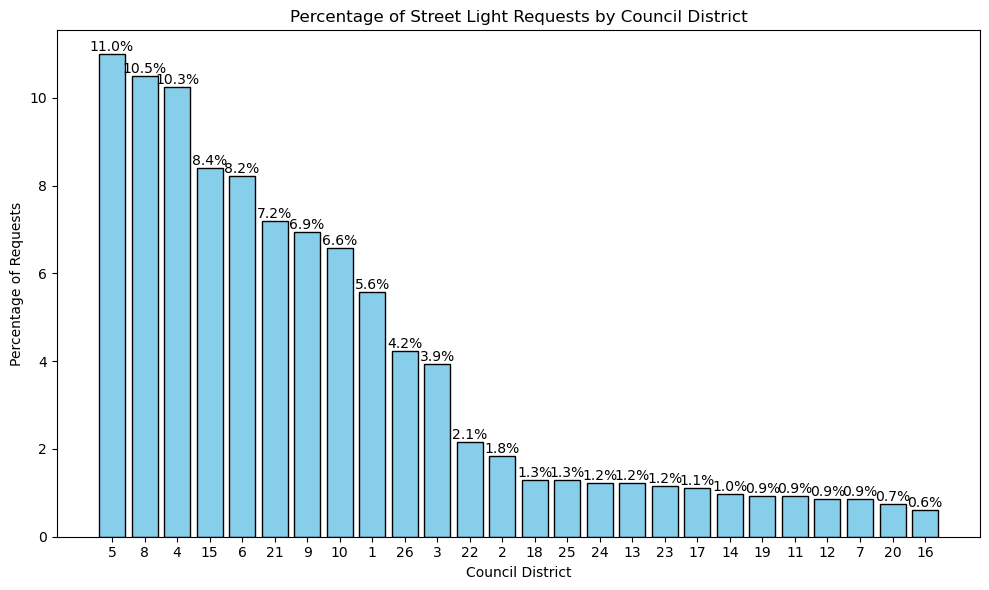

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter for streetlight-related requests
streetlight_df = lights[lights['service_name'].str.contains('Street LightS', case=False, na=False)]

# Step 2: Convert council_district to string
streetlight_df['council_district'] = streetlight_df['council_district'].astype(str)

# Step 3: Count requests and calculate percentages
district_counts = streetlight_df['council_district'].value_counts()
district_df = district_counts.reset_index()
district_df.columns = ['council_district', 'request_count']
district_df['percentage'] = (district_df['request_count'] / district_df['request_count'].sum()) * 100

# Step 4: Sort in descending order by percentage
district_df = district_df.sort_values(by='percentage', ascending=False)

# Step 5: Plot bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    district_df['council_district'],
    district_df['percentage'],
    color='skyblue',
    edgecolor='black'
)

# Step 6: Annotate bars with percentage values
for bar, pct in zip(bars, district_df['percentage']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{pct:.1f}%',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Step 7: Customize chart
plt.title('Percentage of Street Light Requests by Council District')
plt.xlabel('Council District')
plt.ylabel('Percentage of Requests')
plt.tight_layout()
plt.show()



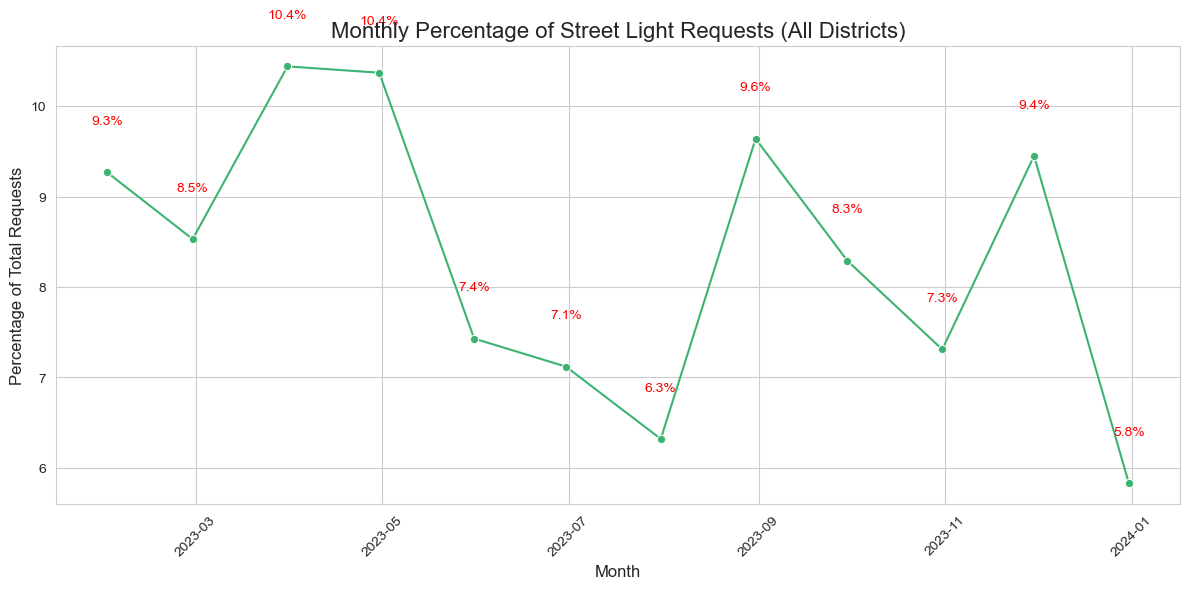

In [44]:

# Step 1: Filter for streetlight-related requests
streetlight_df = lights[lights['service_name'].str.contains('Street LightS', case=False, na=False)]

# Step 2: Convert datetime column
streetlight_df['requested_datetime'] = pd.to_datetime(streetlight_df['requested_datetime'], errors='coerce')

# Step 3: Group by month and count total requests
monthly_total_requests = (
    streetlight_df
    .set_index('requested_datetime')
    .resample('M')
    .size()
    .reset_index(name='request_count')
)

# Step 4: Calculate percentage of each month relative to total
total_requests = monthly_total_requests['request_count'].sum()
monthly_total_requests['percentage'] = (monthly_total_requests['request_count'] / total_requests * 100).round(2)

# Step 5: Plot line chart
plt.figure(figsize=(12, 6))
sns.set_style('whitegrid')
sns.lineplot(
    data=monthly_total_requests,
    x='requested_datetime',
    y='percentage',
    marker='o',
    color='mediumseagreen'
)

# Step 6: Add percentage labels
for i in range(len(monthly_total_requests)):
    date = monthly_total_requests['requested_datetime'][i]
    percent = monthly_total_requests['percentage'][i]
    plt.text(date, percent + 0.5, f"{percent:.1f}%", ha='center', va='bottom', fontsize=10, color='RED')

# Step 7: Customize chart
plt.title('Monthly Percentage of Street Light Requests (All Districts)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Percentage of Total Requests', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [45]:

# Step 1: Get path to user's Documents folder
documents_path = os.path.expanduser("~/Documents")

# Step 2: Define filename
filename = "df_clean_311_2023DATA.csv"

# Step 3: Save DataFrame to CSV
lights.to_csv(os.path.join(documents_path, filename), index=False)

print(f"File saved to: {os.path.join(documents_path, filename)}")


File saved to: C:\Users\atmavizha/Documents\df_clean_311_2023DATA.csv


In [ ]:
lights